---
### Simplified System of linear equations solving for image $X$

Key terms:

$L$ = one-dimensional size for high-resolution image

$M$ = one-dimensional size for low-resolution image

$X$ = $L^2 \times 1$ column vector, represents the ideal image we are trying to recover via solving

$Y_i$ = $M^2 \times 1$ column vector, represents a decimated, downsampled, blurred, noisy image based on $X$

$N$ = the number of low-resolution images

$D$ = the decimation matrix operator of size $M^2 \times L^2$

$H$ = the blur matrix operator of size $L^2 \times L^2$

$S$ = the sharpening operator of size $L^2 \times L^2$, i.e., the laplacian operator

$w_i$ = a weighting scalar, a "confidence factor" for each $Y_i$ (eventually a diagonal matrix?)

$\beta$ = smoothing factor for controlling image sharpening

---

Objective: to solve for $X$ (i.e., $AX = B$) based on the following equation:

$\begin{bmatrix}
  \beta S^T S + (\sum\limits_{i=1}^N w_i) H^TD^TDH
\end{bmatrix}X = \sum\limits_{i=1}^N (w_iH^TD^TY_i)$

Note: In order to reconstruct a high-resolution image from $N$ low-resolution images, the following criteria must be satisfied: $L^2 \leq \min \left\{ \left(s^2 - 2 \right)M^2, NM^2\right\}$, where $s$ is the full support of the blurring kernel (i.e., point-spread function) (as per section III.B of [1]).

[1] M. Elad and A. Feuer, "Restoration of a single superresolution image from several blurred, noisy, and undersampled measured images," in IEEE Transactions on Image Processing, vol. 6, no. 12, pp. 1646-1658, Dec. 1997, doi: 10.1109/83.650118.

---

General information:

- Dataset: GLEAM Small
- Timesteps: 30
- Receivers: 512
- Channels: 1
- $L$ = 100 pixels
- $M$ = 50 pixels
- $N$ = 6 images (30 timesteps / 5 timesteps per image)
- $w_i$ = 1 for all images
- $\beta$ = 1 (I guess?)

Assumptions:
1. The blur kernel $H$ is uniform across all instances of $Y$
2. The decimatimation kernel $D$ is uniform across all instances of $Y$
3. The $w_i$ is uniform across all instances of $Y$, just a confidence of 1.0 ("full confidence")

---

#### To do:

- [x] Generate 6 dataset subsets, containing timesteps each (i.e., 30 time steps / 5 time steps per file)
- [x] Generate one point spread function per dataset subset, for analysis of different
- [x] Generate one point spread function for the whole dataset
- [x] Determine if there is a significant difference between a subset PSF and the full dataset PSF - this will be the blur kernel
- [ ] Determine if the PSF can be reduced (i.e., dont use the full PSF) - what effects might this have?
- [x] Generate an IDFT of the full dataset, $L^2$ pixels
- [x] Genetate an IDFT for each of the subsets, $M^2$ pixels
- [x] Come up with a formula for populating the decimation matrix
- [ ] Come up with a formula for populating the blur matrix 
- [ ] Determine if there is a formula for populating the product of the blur and decimation matrix, such that $H^TD^T = (HD)^T$
- [ ] take the average of optimal betas across support 20 to 47, use that for all supports, plot the error between solved x and true x using the averaged beta, and compare that against another plot which is the "optimal" beta vs support
- [ ] another thing to try, consider trimming the edge of solved x before taking norms and measuring RRMSE, as the convolution matrices are not padded and so convolution is essentially "incomplete" around the image edges. Probably only need to take say 10-15 pixels off all edges, since most of the PSF is noise aside from the center.
- [ ] Another thing to try is to produce a set of Y images which are only representative of a single source, like a PSF. Then I could run the SOLE algorithm to determine what the effects of solving are against the curve of a point source, by taking a middle slice of the image (like I do when inspecting the actual PSF). Could examine what happens when using different supports and beta terms to see which lines up best with the true curve.
 - [ ] I need to modify the decimation matrix function to support more than just 4 neighbours (or 1/2 decimation).
 - [ ] Modify the project so it is more like a library, where I can call my own functions in my desired order. This would make repeating experiments easier than one flat notebook.
 - [ ] Implement the laplacian of gaussian function, so that I can have a dynamically sized laplacian instead of a fixed 3x3 (note: requires another config to specify laplacian support size, and a sigma value to determine curve spread, or are they roughly the same type of thing?)
 - [ ] Try running the algorithm with the averaged beta, using different sized LoGs and different PSF supports to see what happens re: rrmse
 - [ ] Figure out how I can get the sigma using a point of inflection of a large PSF (something like that?)
 - [ ] Implement assertion to confirm number of y samples and decimation factor follow critical formula from adaptive filtering approach paper
 - [ ] June 9 - Andrew suggests updating my decimation routine to be more dynamic, supporting powers of 2 or even arbitrary amounts, not sure how hard that is? He suggests experimenting with variable decimation and using a fixed optimal beta, fixed optimal sigma, and fixed PSF support (one of the higher end supports which seem stable, say 51? Could probably even just do the full PSF of 99x99 realistically

---

#### Notes:

- If one takes the $\beta S^T S$ portion of $A$ and multiplies it by the solved $X$;  assuming the result is not normalised, one can observe the contribution of beta-influenced laplacian sharpening towards $B$. It appears to float around 10% of the second portion of $A$ (the decimated PSF) multiplied by the solved $X$. Taking the sum of these two separate portions of $AX$ allow one to produce $B$. It appears that the laplacian sharpening portion of $A$ does meaningfully contribute to help find a reasonable solution to $X$, and doesnt appear to be dominating (i.e., drowning out) the decimated PSF portion of $A$.
- Essentially, we dont want the beta-driven laplacian to dominate the sharpened PSF, otherwise you end up with effectively an overly smooth image $X$, and the technique becomes less useful / less impressive. We want to solve for $X$, such that beta helps us resolve a more accurate image $X$ which isnt just noise (a lack of structure, looks like static), and also doesnt look too smooth. If solving was less useful because we required large beta terms, then we might as well just average our set of $Y$ low-resolution images instead since its computationally cheaper?
 - Implement nifty gridder as a jupyter notebook - Andrew wants to see an image of true x, solved x, and nifty x
 - Andrew suggestions that in the future, a good method for analysing the effectiveness of this technique would be to compare the extractable sources and compare against a sky model (possibly Fred Dulwich has this?). It seems RRMSE is "misleading", in the sense that images produced by this technique arent so noisy, sources appear more gaussian-like and less like the dirty beam.
 - Furthermore, I should have a look at how this technique compares against the direct image model, versus an image produced by means of gridding (i.e., w-projection, nifty).
---

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext memory_profiler

from linear_system_super_resolution import * # not best practice, but oh well

import numpy as np

import cupy as cp
from cupyx.scipy.sparse.linalg import cg as cg_gpu
from cupyx.scipy.sparse.linalg import aslinearoperator as aslinearoperator_gpu
from cupyx.scipy.sparse import csr_matrix as csr_matrix_gpu
# from cupyx.scipy.sparse.linalg import lsqr as cuda_sparse_solve

import matplotlib.pyplot as plt

from scipy.signal import convolve2d
from scipy.stats import norm
from scipy.sparse import csr_matrix, bsr_matrix, dia_matrix, diags, csr_array
from scipy.sparse.linalg import bicg, bicgstab, cg, cgs, gmres, lgmres, minres, qmr, gcrotmk, tfqmr, lsqr, lsmr, aslinearoperator
from scipy.linalg import solve
from skimage import data, io, color
from skimage.transform import resize

from joblib import Parallel, delayed

# from sparse_dot_mkl import dot_product_mkl as parallel_mult

plt.rcParams['figure.figsize'] = [15, 15]

#### Configuration and data set up...

In [2]:
timesteps = 30 # total timesteps
timesteps_per_y = 1
l = 800
m = 200
n = timesteps // timesteps_per_y
downsample = l // m
w = np.ones(n)
β = 10.0 #0.550868006556238
blur_kernel_support = 151
dh_matrix_batch_size = m**2 // 4

# Note: flowchart for selecting solver routine might be useful..
# https://www.mathworks.com/help/matlab/math/iterative-methods-for-linear-systems.html
solver = gcrotmk

# False = use static 3x3 laplacian kernel
# True = use customisable laplacian of gaussian kernel
use_laplacian_of_gaussian = False

# False = solve using CPU based scipy library
# True = solve using GPU based cupy library
use_accelerated_solving = False

# all time steps direct image
filename = f"../datasets/gleam_small/images/multi_source/direct_image_ts_0_29_{l}x{l}.bin"
x_true = normalise(np.fromfile(filename, dtype=np.float32).reshape(l, l))
# show_image(x_true, "True X")

filename = f"../datasets/gleam_small/images/multi_source/direct_psf_ts_0_29_{l}x{l}.bin"
x_psf = np.fromfile(filename, dtype=np.float32).reshape(l, l)
# show_image(x_psf, "Untrimmed PSF")
# plt.plot(x_psf[x_psf.shape[0]//2])
# plt.show()

blur_kernel_support_half = (blur_kernel_support - 1) // 2
trim_min = l//2 - (blur_kernel_support_half)
trim_max = l//2 + blur_kernel_support_half + 1
print(f"PSF min/max/support: {trim_min}, {trim_max}, {blur_kernel_support}")
# x_psf = x_psf.reshape(l, l)[psf_min:psf_max, psf_min:psf_max]
x_psf_trimmed = x_psf.copy()[trim_min : trim_max, trim_min : trim_max]
x_psf_trimmed /= np.sum(x_psf_trimmed)
# print(np.sum(x_psf_trimmed))
# plt.plot(x_psf_trimmed[x_psf_trimmed.shape[0]//2])
# plt.show()

# print(f"PSF Shape: {x_psf_trimmed.shape[0]}")
# show_image(x_psf_trimmed, "PSF")

print(f"l^2:                      {l**2}")
print(f"(psf_support - 2) * m^2:  {(blur_kernel_support - 2) * m**2}")
print(f"n * m^2:                  {n * m**2}")

# Determine whether we have the right criteria to perform super-resolution imaging to obtain X
if l**2 <= np.minimum((blur_kernel_support - 2) * m**2, n * m**2):
    print("Super-resolution imaging technically possible, continuing...\n")
else:
    raise ValueError("High-resolution image not possible to reproduce from your set up, review your configuration against this if statement conditional.\n")

# Storing all low-res images as layered stack
y = np.zeros((n, m, m))

# batched time steps direct images
for i in np.arange(n):
    timestep_range_start = i * timesteps_per_y
    timestep_range_end = timestep_range_start + timesteps_per_y
    filename = f"../datasets/gleam_small/images/multi_source/direct_image_ts_{timestep_range_start}_{timestep_range_end - 1}_{m}x{m}.bin"
    y[i] = np.fromfile(filename, dtype=np.float32).reshape(m, m)
    y[i] = normalise(y[i])

s = generate_s_matrix(l)

PSF min/max/support: 325, 476, 151
l^2:                      640000
(psf_support - 2) * m^2:  5960000
n * m^2:                  1200000
Super-resolution imaging technically possible, continuing...




In [3]:
# %time h = generate_h_matrix(l, x_psf_trimmed)

# Decimation matrix
# d = generate_d_matrix(l, 4)

# show_sparse_matrix(d, "D")
# d_numpy_size_bytes = d.size * d.itemsize
# print(f"D matrix uncompressed sparse: {d_numpy_size_bytes / 10**6} MB")
# d = bsr_matrix(d)
# print(f"D matrix memory usage: {matrix_memory(d)}MB")
# print(f"D matrix density: {matrix_density(d)}%")
# print(f"D matrix reduced by {100 - (d_csr_matrix_bytes / d_numpy_size_bytes * 100)}%\n")

# dh = parallel_mult(d, h)
# %time dh = d @ h
# show_sparse_matrix(dh, "DH")

# print(f"DH matrix memory usage: {matrix_memory(dh)}MB")
# print(f"DH matrix density: {matrix_density(dh)}%")

%lprun -f generate_dh_matrix_batched dh = generate_dh_matrix_batched(x_psf_trimmed, l, downsample, dh_matrix_batch_size)

# show_sparse_matrix(dh_numba, "DH Numba")
print(f"DH matrix memory usage: {matrix_memory(dh)}MB")
    
# Notes to self: seems like lap_gauss_σ sits around 1.41 for this example, any higher or lower results in worse RRMSE. Changing the psf_central_support makes no difference, and taking more samples (i.e. num)
# just means that lap_gauss_σ is multiplied by the factor of difference (i.e., double the num samples needs double the lap_gauss_σ). Also found that beta is best multiplied by 4.0, not 16 (the square).
# Not sure what to do from here... seems like the laplacian of gaussian doesnt really serve any beneficial purpose...

DH matrix memory usage: 7224.115204MB


Timer unit: 1e-06 s

Total time: 32.0088 s
File: /supy_res/notebooks/linear_system_super_resolution.py
Function: generate_dh_matrix_batched at line 191

Line #      Hits         Time  Per Hit   % Time  Line Contents
   191                                           def generate_dh_matrix_batched(kernel, high_res_dim, downsample, dh_matrix_batch_size):
   192                                               
   193         1          1.0      1.0      0.0      low_res_dim = high_res_dim // downsample
   194                                               
   195                                               # %lprun -f calculate_d_origins d_origins = calculate_d_origins(high_res_dim, downsample)
   196         1        340.0    340.0      0.0      d_origins = calculate_d_origins(high_res_dim, downsample)
   197                                               
   198                                               # %lprun -f produce_stacked_kernel stacked_kernel = produce_stacked_kernel(kernel, d

#### Setting up the right hand side of the equation $AX = B$, where $B = \sum\limits_{i=1}^N (w_iH^TD^TY_i)$

In [4]:
b = generate_b_image(l, n, w, dh, y)
# show_image(b.reshape(l, l), "B")

#### Setting up the right hand side of the equation $AX=B$, where $A = \begin{bmatrix}
  \beta S^T S + (\sum\limits_{i=1}^N w_i) H^TD^TDH
\end{bmatrix}$

In [5]:
# %time lhs = (β * (s @ csr_matrix.transpose(s)))
# print(f"A_LHS l2 norm: {np.sum(lhs**2)}")
# print(f"A_LHS matrix memory usage: {matrix_memory(lhs)}MB")
# print(f"A_LHS matrix density: {matrix_density(lhs)}%")

# # This section is painfully slow... like 3-4 mins
# %time rhs = ((csr_matrix.transpose(dh) @ dh) * np.sum(w))
# print(f"A_RHS matrix memory usage: {matrix_memory(rhs)}MB")
# print(f"A_RHS matrix density: {matrix_density(rhs)}%")

# %time a = lhs + rhs
# print(f"A matrix memory usage: {matrix_memory(a)}MB")
# print(f"A matrix density: {matrix_density(a)}%")

# runtime for scipy mat mul = 4 min 26 sec
# runtime for parallel mult = 

# a = bsr_matrix.toarray(a)
# show_image(a.reshape(l**2, l**2), "A")
# print(f"A l2 norm: {np.linalg.norm(a)}")

#### Now solve for $X$...

/tmp/ipykernel_4031/481469924.py:20: DeprecationWarning: scipy.sparse.linalg.gcrotmk called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  xlo, info = solver(alo, b, maxiter=15, callback=show_iter_solution) #, callback_type='x')


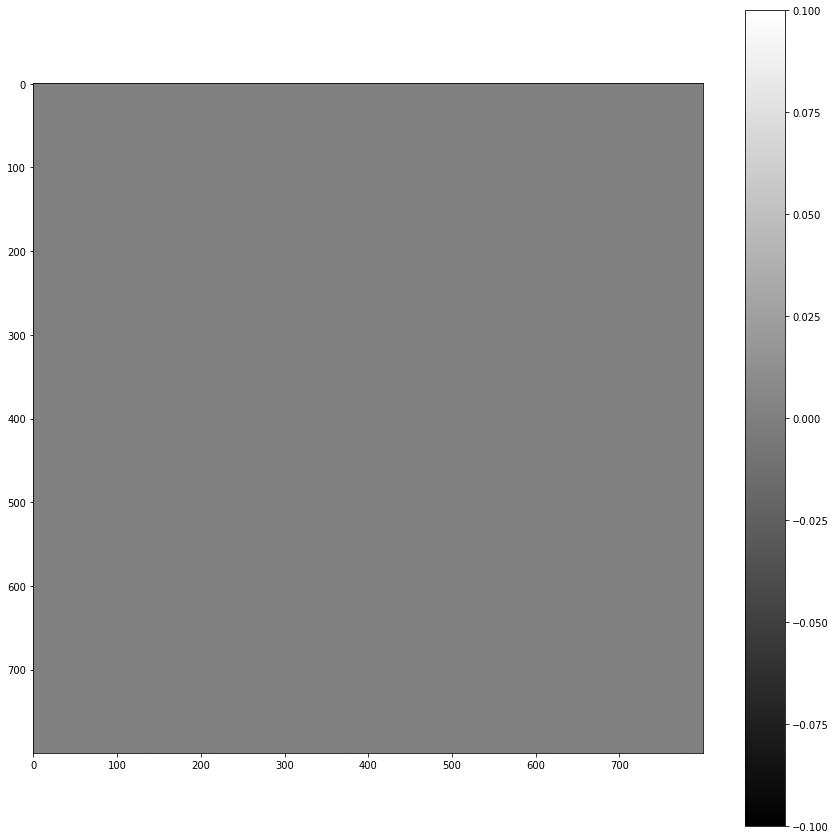

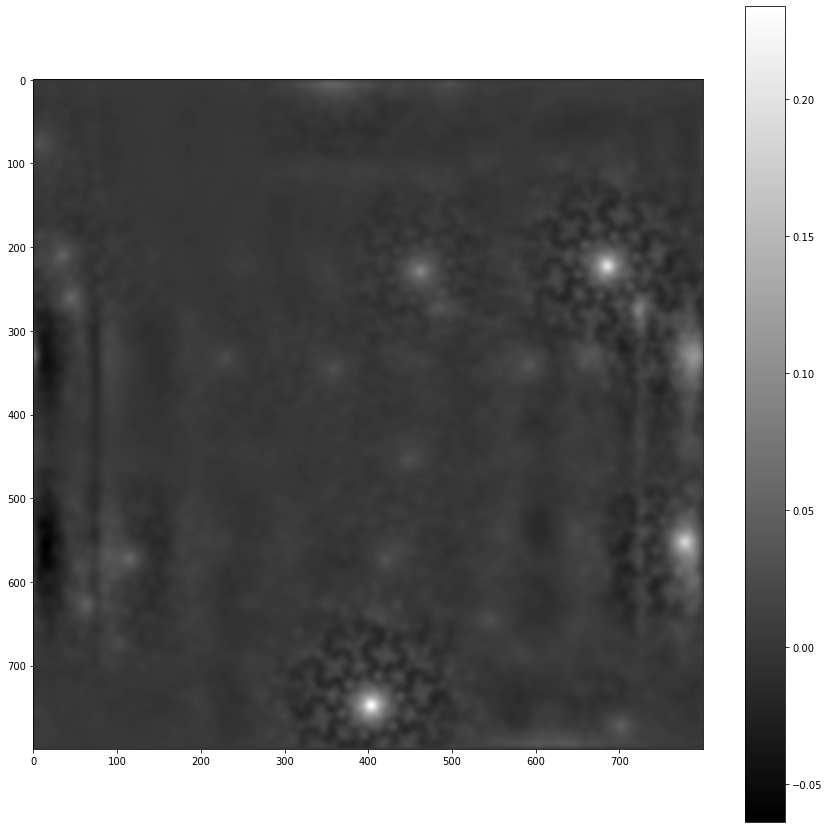

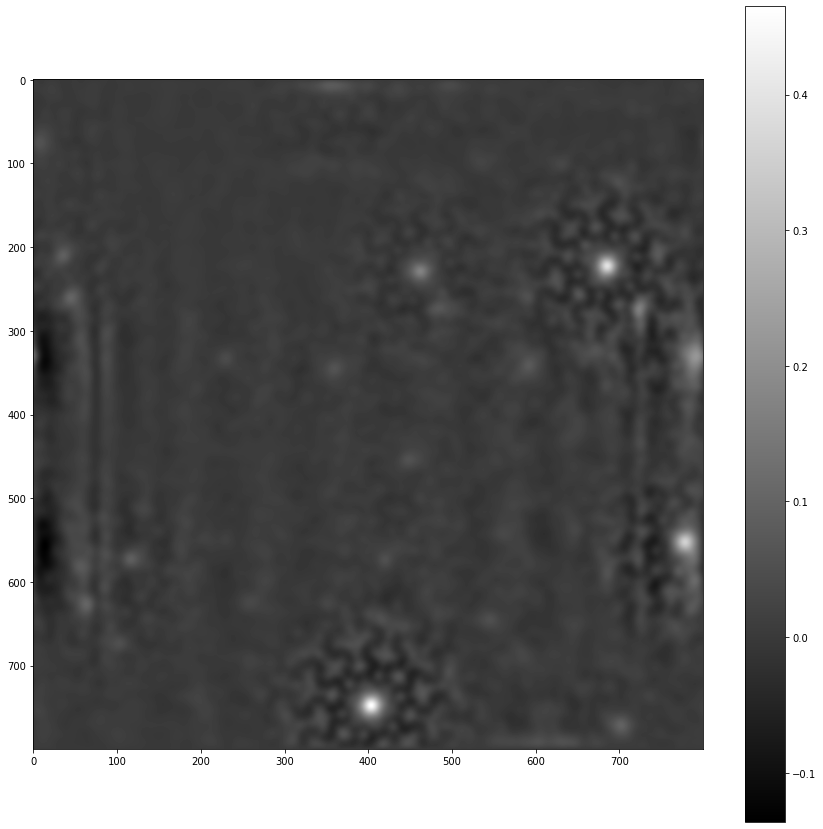

In [ ]:

use_accelerated_solving = False

if use_accelerated_solving:
    # CUPY WORK START
    s_gpu = csr_matrix_gpu(s)
    dh_gpu = csr_matrix_gpu(dh)
    slo_gpu = aslinearoperator_gpu(s_gpu) # does s need to be put onto gpu?
    dhlo_gpu = aslinearoperator_gpu(dh_gpu) # does dh need to be put onto gpu?
    b_gpu = cp.array(b)
    w_sum = np.sum(w)
    alo_gpu = (β * (slo_gpu.T @ slo_gpu)) + ((dhlo_gpu.T @ dhlo_gpu) * w_sum)
    xlo_gpu, info = cg_gpu(alo_gpu, b_gpu, maxiter=100)
    # print(f"GPU INFO: {info}")
    xlo = cp.asnumpy(xlo_gpu).reshape(l, l)
    # CUPY WORK END
else:
    slo = aslinearoperator(s)
    dhlo = aslinearoperator(dh)
    alo = (β * (slo.T @ slo)) + ((dhlo.T @ dhlo) * np.sum(w))
    xlo, info = solver(alo, b, maxiter=15, callback=show_iter_solution) #, callback_type='x')
    xlo = xlo.reshape(l, l)
    # print(f"INFO: {info}")

# x, _ = solver(a, b, maxiter = 1)
# x = x.reshape(l, l)
# show_image(normalise(x), "Solved X", flip_x_axis=True)
# print(f"Beta: {β}")
# print(f"RRMSE: Solved X and True X -> {rrmse(normalise(x), normalise(x_true))}")
# print(f"RRMSE: Solved X and B -> {rrmse(normalise(x), normalise(b.reshape(l, l)))}")
# print(f"True X peak location: {np.unravel_index(np.argmax(x_true, axis=None), x_true.shape)}")
# print(f"Solved X peak location: {np.unravel_index(np.argmax(x, axis=None), x.shape)}")

# show_image(normalise(xlo), "Solved X (Linear Operator)", flip_x_axis=True)
# show_image(normalise(x_true), "True X", flip_x_axis=True)

print(f"Beta: {β}")
print(f"RRMSE: Solved X and True X -> {rrmse(normalise(xlo), normalise(x_true))}")
print(f"RRMSE: Solved X and B -> {rrmse(normalise(xlo), normalise(b.reshape(l, l)))}")
print(f"RRMSE: B and True X -> {rrmse(normalise(b.reshape(l, l)), normalise(x_true))}")
print(f"True X peak location: {np.unravel_index(np.argmax(x_true, axis=None), x_true.shape)}")
print(f"Solved X peak location: {np.unravel_index(np.argmax(xlo, axis=None), xlo.shape)}")

# plt.plot(normalise(xlo[202, :]))
# plt.plot(normalise(x_true[200, :]))
# plt.show()

# print(rrmse(normalise(x), normalise(xlo)))